In [1]:
import datasets

dataset_wmt19 = datasets.load_dataset("wmt19", 'ru-en')
dataset_open_subtitles = datasets.load_dataset("open_subtitles", lang1="en", lang2="ru")


print("Size of WMT19 dataset: ", len(dataset_wmt19['train']))
print("Size of Open Subtitles dataset: ", len(dataset_open_subtitles['train']))

/Users/sergejsorin/study/hse_4_year_2024-2025/ds/project/.env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Size of WMT19 dataset:  37492126
Size of Open Subtitles dataset:  25910105


In [3]:
dataset_open_subtitles['train'][0]

{'id': '0',
 'meta': {'year': 0,
  'imdbId': 1730059,
  'subtitleId': {'en': 5554838, 'ru': 4603300},
  'sentenceIds': {'en': [1], 'ru': [2]}},
 'translation': {'en': 'Kids can get pretty much anything they want in the yard, as long as they can afford it.',
  'ru': 'Дети могут достать во дворе почти всё что угодно до тех пор, пока могут себе это позволить.'}}

# Подбор датасета и токенайзера

Так как мы хотим построить маленькую, но эффективную модель, нам нужно определить размер контекстного окна трансформера и токенайзер, который будет использоваться.

Чем лучше токенайзер - тем лучше он сжимает входные данные в токены, но с другой стороны - тем больше разрастается матрица входных и выходных эмбедингов (матрица размера (размер словаря) * (размерность эмбедингов в модели)).

Поэтому мы возьмем несколько датасетов ("open_subtitles", lang1="en", lang2="ru") и ("wmt19", 'ru-en'), и на каждом посчитаем среднее количество токенов в фразе, и какой процент из них влезет в 64 токена. Так как вычислительные затраты растут линейно от размера датасета, будем так же примерно вычислять "сложность" датасета как (средний размер данных в токенах) * (размер датасета)



In [25]:
from transformers import AutoTokenizer
tokenizers_names = [
    "Helsinki-NLP/opus-mt-en-ru",
    "facebook/mbart-large-50",
    "google/mt5-base",
    "facebook/wmt19-ru-en",
    "t5-base",
    "xlm-roberta-base"
]

tokenizers = []
for name in tokenizers_names:
    tokenizer = AutoTokenizer.from_pretrained(name)
    tokenizers.append({"name": name, "tokenizer": tokenizer})
    

In [30]:
import pandas as pd
pd.options.display.float_format = '{:,.0f}'.format
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import numpy as np

def analyze_dataset(dataset_name, tokenizers, sample_size=10000):
    if dataset_name == "open_subtitles":
        dataset = datasets.load_dataset("open_subtitles", lang1="en", lang2="ru")
        src_lang, tgt_lang = 'en', 'ru'
    elif dataset_name == "wmt19":
        dataset = datasets.load_dataset("wmt19", 'ru-en')
        src_lang, tgt_lang = 'en', 'ru'
    
    results = []
    
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    
    for idx, tok_dict in enumerate(tokenizers):
        name = tok_dict["name"]
        tokenizer = tok_dict["tokenizer"]
        
        src_lengths = []
        tgt_lengths = []
        
        for i in tqdm(range(sample_size), desc=name):
            sample = dataset['train'][i]
            if dataset_name == "open_subtitles":
                src_text = sample['translation'][src_lang]
                tgt_text = sample['translation'][tgt_lang]
            else:
                src_text = sample['translation'][src_lang]
                tgt_text = sample['translation'][tgt_lang]
            
            src_lengths.append(len(tokenizer.encode(src_text)))
            tgt_lengths.append(len(tokenizer.encode(tgt_text)))
            
        src_lengths = np.array(src_lengths)
        tgt_lengths = np.array(tgt_lengths)
        
        # Plot
        ax = axes[idx]
        ax.hist(src_lengths, bins=50, alpha=0.5, label=f'{src_lang} (fit: {(src_lengths <= 128).mean() * 100:.1f}%)')
        ax.hist(tgt_lengths, bins=50, alpha=0.5, label=f'{tgt_lang} (fit: {(tgt_lengths <= 128).mean() * 100:.1f}%)')
        ax.axvline(x=128, color='r', linestyle='--')
        ax.set_title(f'{name}\nVocab: {len(tokenizer.get_vocab()):,}')
        ax.legend()
        
        # Collect stats
        results.append({
            'tokenizer': name,
            'vocab_size': len(tokenizer.get_vocab()),
            f'{src_lang}_mean_length': src_lengths.mean(),
            f'{tgt_lang}_mean_length': tgt_lengths.mean(),
            f'{src_lang}_median_length': np.median(src_lengths),
            f'{tgt_lang}_median_length': np.median(tgt_lengths),
            f'{src_lang}_fit_128': (src_lengths <= 128).mean() * 100,
            f'{tgt_lang}_fit_128': (tgt_lengths <= 128).mean() * 100,
            'complexity_score': len(tokenizer.get_vocab()) * (src_lengths.mean() + tgt_lengths.mean()) / 2
        })
    
    plt.tight_layout()
    return pd.DataFrame(results).sort_values('complexity_score')


Helsinki-NLP/opus-mt-en-ru:   0%|          | 0/10000 [00:00<?, ?it/s]

facebook/mbart-large-50:   0%|          | 0/10000 [00:00<?, ?it/s]

google/mt5-base:   0%|          | 0/10000 [00:00<?, ?it/s]

facebook/wmt19-ru-en:   0%|          | 0/10000 [00:00<?, ?it/s]

t5-base:   0%|          | 0/10000 [00:00<?, ?it/s]

xlm-roberta-base:   0%|          | 0/10000 [00:00<?, ?it/s]

,tokenizer,vocab_size,en_mean_length,ru_mean_length,en_median_length,ru_median_length,en_fit_128,ru_fit_128,complexity_score
3,facebook/wmt19-ru-en,31232,17,9,12,7,100,100,"403,878"
4,t5-base,32100,12,23,9,18,100,100,"556,250"
0,Helsinki-NLP/opus-mt-en-ru,62518,12,29,9,23,100,99,"1,279,900"
5,xlm-roberta-base,250002,13,10,10,9,100,100,"2,867,885"
1,facebook/mbart-large-50,250054,13,10,10,9,100,100,"2,868,482"
2,google/mt5-base,250100,12,11,10,9,100,100,"2,945,128"


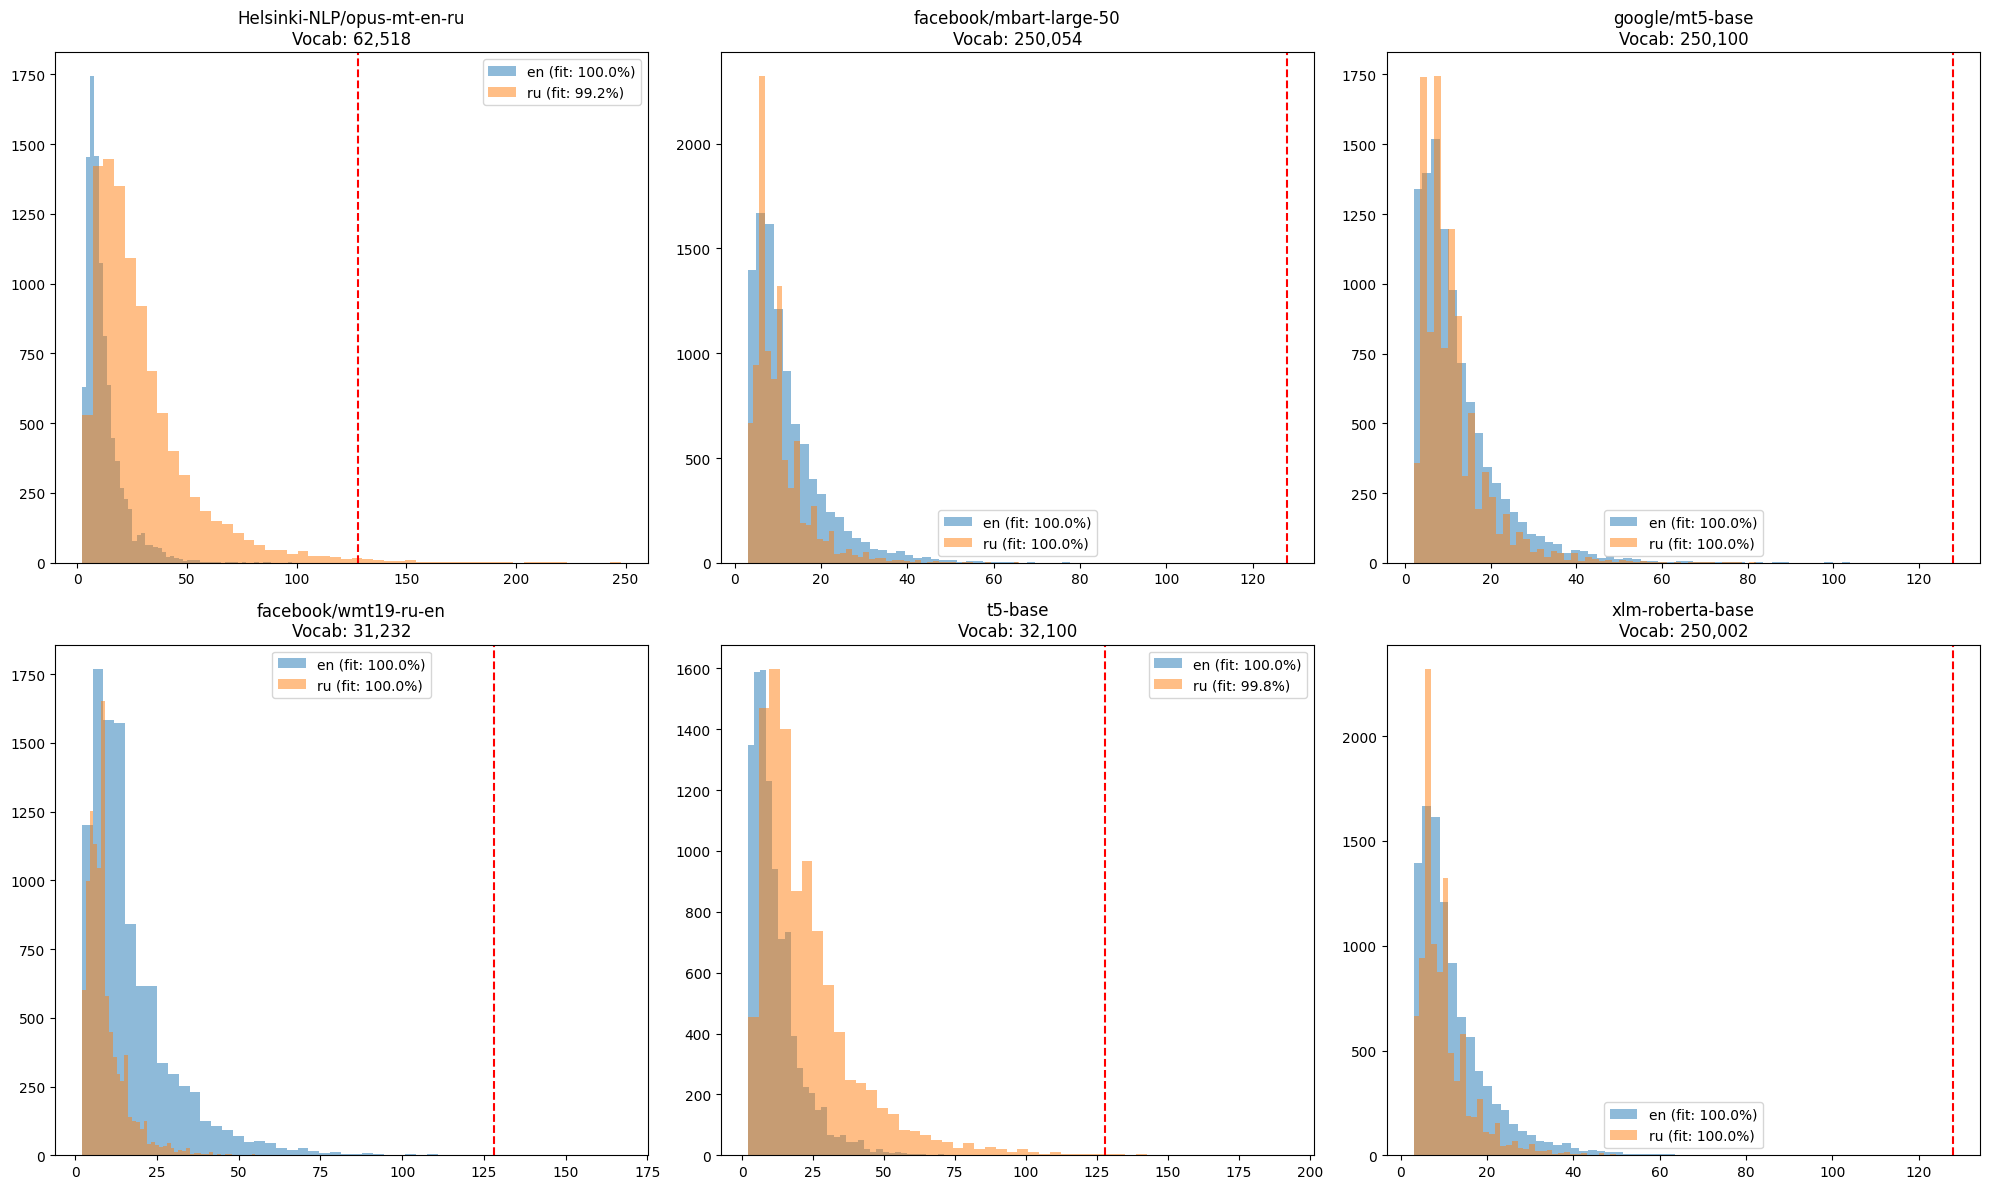

In [34]:
df_subtitles = analyze_dataset("open_subtitles", tokenizers)
display(df_subtitles)
df_subtitles.to_csv("open_subtitles_tokenizers.csv", index=False)

Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]

Helsinki-NLP/opus-mt-en-ru:   0%|          | 0/10000 [00:00<?, ?it/s]

facebook/mbart-large-50:   0%|          | 0/10000 [00:00<?, ?it/s]

google/mt5-base:   0%|          | 0/10000 [00:00<?, ?it/s]

facebook/wmt19-ru-en:   0%|          | 0/10000 [00:00<?, ?it/s]

t5-base:   0%|          | 0/10000 [00:00<?, ?it/s]

xlm-roberta-base:   0%|          | 0/10000 [00:00<?, ?it/s]

,tokenizer,vocab_size,en_mean_length,ru_mean_length,en_median_length,ru_median_length,en_fit_128,ru_fit_128,complexity_score
3,facebook/wmt19-ru-en,31232,24,17,10,9,98,100,"648,230"
4,t5-base,32100,17,37,8,10,99,92,"862,618"
0,Helsinki-NLP/opus-mt-en-ru,62518,16,47,8,10,100,88,"1,988,679"
5,xlm-roberta-base,250002,17,18,9,9,100,100,"4,368,947"
1,facebook/mbart-large-50,250054,17,18,9,9,100,100,"4,369,856"
2,google/mt5-base,250100,17,19,8,8,100,99,"4,477,753"


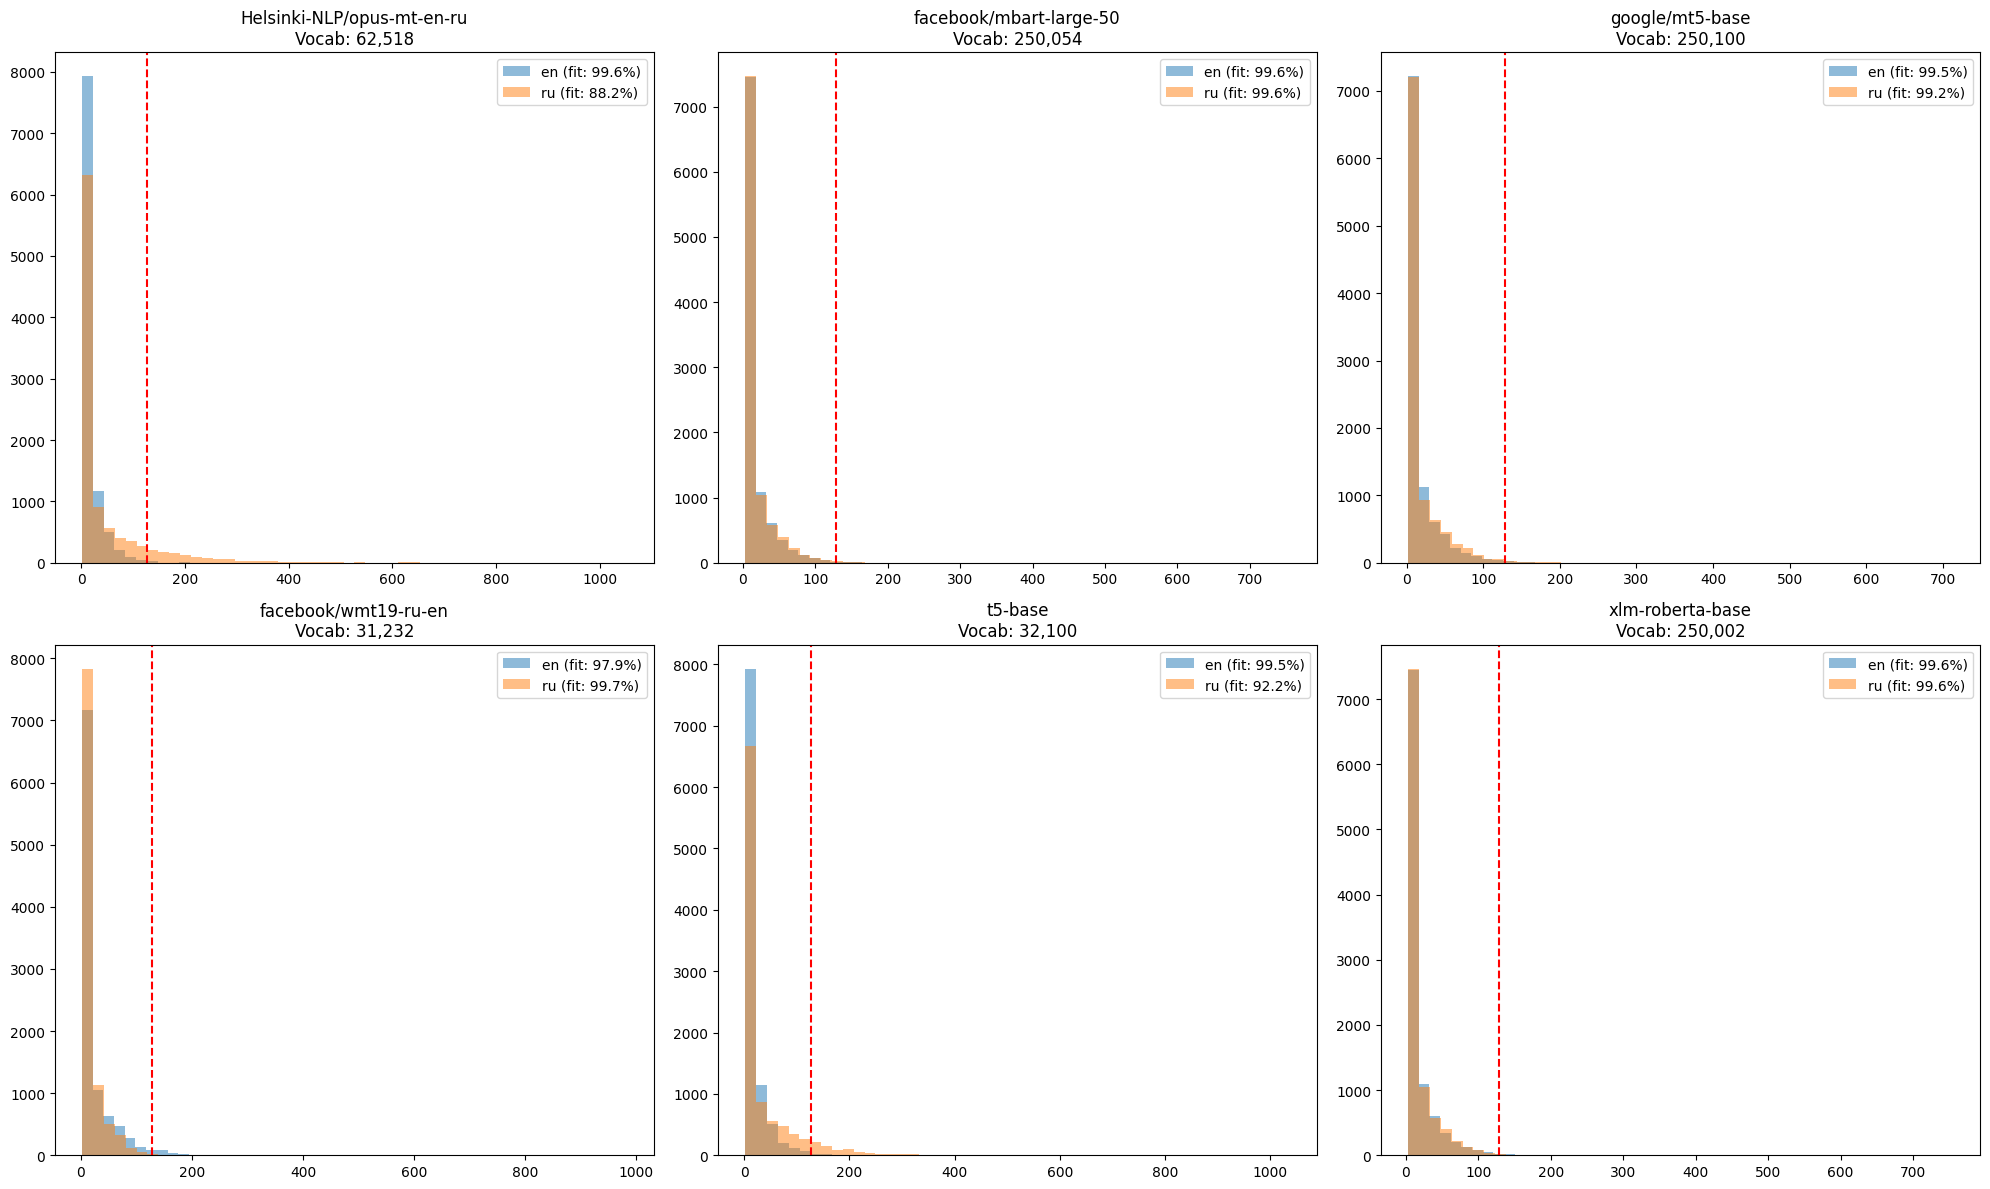

In [33]:
df_wmt = analyze_dataset("wmt19", tokenizers)
display(df_wmt)
df_wmt.to_csv("wmt19_tokenizers.csv", index=False)

Вывод

Используем `facebook/wmt19-ru-en`	, так как он самый эффективный, и хорошо обрабатывает все датасеты

In [37]:
import random

def show_samples(dataset_name, n=10):
    if dataset_name == "open_subtitles":
        ds = datasets.load_dataset("open_subtitles", lang1="en", lang2="ru")['train']
    else:
        ds = datasets.load_dataset("wmt19", 'ru-en')['train']
    
    indices = random.sample(range(len(ds)), n)
    samples = []
    
    for idx in indices:
        sample = ds[idx]
        if dataset_name == "open_subtitles":
            samples.append({
                'en': sample['translation']['en'],
                'ru': sample['translation']['ru']
            })
        else:
            samples.append({
                'en': sample['translation']['en'],
                'ru': sample['translation']['ru']
            })
    
    df = pd.DataFrame(samples)
    print(f"\n{dataset_name} samples:")
    return df

print("OpenSubtitles:")
display(show_samples("open_subtitles"))

print("\nWMT19:")
display(show_samples("wmt19"))

OpenSubtitles:

open_subtitles samples:


,en,ru
0,It's very important.,Это очень важно.
1,People here like to gossip more than anything,Народ здесь любит сплетничать больше всего.
2,They are not French.,Это не французские сигареты.
3,"Look, I get up tomorrow, I get a job here, Zip...","Слушай, завтра я проснусь, найду работу, тяп-л..."
4,"This is San Fran, not the Caribbean.","Это Сан-Франциско, а не Карибы."
5,Up in Medford we take our time making up our m...,Там мы не спешим с выводами.
6,He makes people disappear.,И устраняет людей.
7,Good to hear.,Рад тебя слышать.
8,I don't know why I listen to you.,"Не знаю, почему я вообще тебя слушаю."
9,"So I figured, uh, low-key family dinner, no of...","Значит, э-э, тихий семейный обед, без официаль..."



WMT19:


Resolving data files:   0%|          | 0/28 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/28 [00:00<?, ?it/s]


wmt19 samples:


,en,ru
0,Source: Agence France-Presse from the Kuwait N...,Агентство Франс Пресс со ссылкой на сообщение ...
1,Museums in Phnom Penh,Музеи Пномпеня
2,While he was flexible regarding paragraph 2 (b...,Хотя он занимает гибкую позицию в отношении пу...
3,I also wish to commend the Director-General of...,Хочу также поблагодарить Генерального директор...
4,Recalling its resolutions 57/219 of 18 Decembe...,ссылаясь на свои резолюции 57/219 от 18 декабр...
5,"However, the question has recently been raised...","Однако, в последнее время был поднят вопрос, о..."
6,Pühtitsa Convent,Пюхтицкий монастырь
7,Resumed 1997 session of the Committee on Non-G...,Возобновленная сессия Комитета по неправительс...
8,The low service weight of 16 t and the almost ...,Низкий снаряженный вес 16 тонн и почти идеальн...
9,The Secretary-General was requested to submit ...,Генеральная Ассамблея просила Генерального сек...


Выберем датасет open_subtitles, так как он интереснее, и лучше показывает базовый перевод (без сложных терминов, в которых модели нужно будет научиться разбираться)